# Ghouls, Goblins, and Ghosts... Boo!

##### Temat konkursu:
Kaggle jest nawiedzony i potrzebna jest mu pomoc. Po miesiącu dokonywania obserwacji naukowych i dokładnych pomiarów ustaliliśmy, że 900 ghuli, duchów i goblinów atakuje naszą uczelnię i straszy naukowców zajmujących się danymi. Podczas stosowania różnych metod niedających efektów stwierdziliśmy, że uczenie maszynowe jest jedyną odpowiednią metodą na pozbycie się nieproszonych gości.

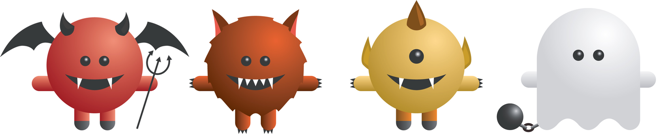

##### Cel konkursu:
Z 900 upiorów zidentyfikowano 371 stworzeń. Naszym celem jest wykorzystanie zebranych danych, aby sklasyfikować upiory na ghoule, gobliny i duchy. Wykorzystamy pomiary takie jak: długość kości, nasilenie zgnilizny, stopień bezduszności i inne cechy, aby rozpoznać intruzów. 

## Rozwiązanie problemu:

Zaczynamy od importowania zbioru danych. Mamy do dyspozycji 2 pliki danych:

     train.csv -> dane treningowe.
     test.csv -> dane testowe, dla których musimy przewidzieć kategorię.
     
Nastepnie sprawdzamy czy jakaś kolumna ma brakujące wartości.

In [5]:
import pandas
import numpy as np

train_set = pandas.read_csv("train.csv")
test_set = pandas.read_csv("test.csv")
train_set = train_set.drop('id',axis=1)
 
print(train_set.describe())

       bone_length  rotting_flesh  hair_length    has_soul
count   371.000000     371.000000   371.000000  371.000000
mean      0.434160       0.506848     0.529114    0.471392
std       0.132833       0.146358     0.169902    0.176129
min       0.061032       0.095687     0.134600    0.009402
25%       0.340006       0.414812     0.407428    0.348002
50%       0.434891       0.501552     0.538642    0.466372
75%       0.517223       0.603977     0.647244    0.600610
max       0.817001       0.932466     1.000000    0.935721


Na otrzymanej tabeli widać, że każda kolumna zawiera taką samą ilość danych, a zakres wartości mieści się w przedziale od 0 do 1. Podany zestaw danych posiada kolumnę o nazwie "typ", która zawiera wartości należące do danej kategorii. W następnym kroku dokonamy konwersji kategorii ciągów na wartości całkowite.

In [6]:
train_set['type'], categories = train_set['type'].factorize()
print(train_set.describe())

       bone_length  rotting_flesh  hair_length    has_soul        type
count   371.000000     371.000000   371.000000  371.000000  371.000000
mean      0.434160       0.506848     0.529114    0.471392    0.967655
std       0.132833       0.146358     0.169902    0.176129    0.814749
min       0.061032       0.095687     0.134600    0.009402    0.000000
25%       0.340006       0.414812     0.407428    0.348002    0.000000
50%       0.434891       0.501552     0.538642    0.466372    1.000000
75%       0.517223       0.603977     0.647244    0.600610    2.000000
max       0.817001       0.932466     1.000000    0.935721    2.000000


Teraz w kolumnie "type" widać numeryczny zbiór wartości.
Użyliśmy drugiej zmiennej nazwanej "categories", która zawiera informację pozwalające nam przywrócić proces konwersji.
W celu analizy danych, stworzymy wykres współzależności podanych cech od siebie.

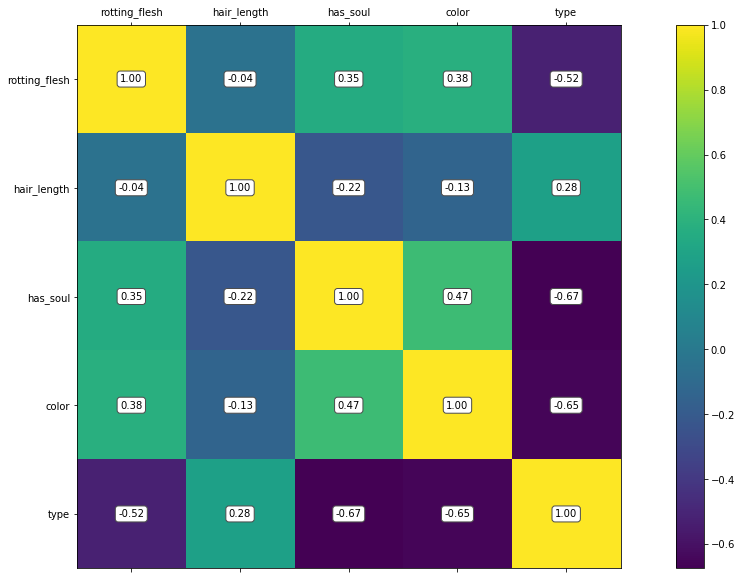

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
aux_plot = fig.add_subplot(111)
fig.colorbar(aux_plot.matshow(train_set.corr()))

aux_plot.set_xticklabels(train_set.columns)
aux_plot.set_yticklabels(train_set.columns)

for (i, j), z in np.ndenumerate(train_set.corr()):
    aux_plot.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round',facecolor='white', edgecolor='0.3'))

plt.show()

Wykres pomoże nam przeanalizować funkcje i ich wpływ na kolumnę "type". Na wykresie widać,że kolumna "type" ma wysoką wartość ujemnej współzależności z kolumną "color", "has_soul" i "rotting_flesh", natomiast korelacja z "hair_lenght" nie jest dla nas znacząca. 
Analizując współzależność między innymi cechami potworów widać, że cecha "has_soul" i "hair_length" a także "has_soul" z "rotting_flesh" mają interesującą nas wartość. W kolejny kroku wyodrębnimy kilka nowych fukncji.
Pomnożymy "has_soul" z "hair_length", aby uzyskać nową cechę, która będzie znacznie bardziej współzależna z kolumną "type". W tym celu tworzymy klasę odpowiedzialną za ten proces.

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class CreateExtraFeatures(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X['hair_soul'] = X['hair_length'] * X['has_soul']
        X['flesh_soul'] = X['rotting_flesh'] * X['has_soul']
        return np.c_[X]

W tej klasie tworzymy 2 nowe funkcje, łącząc 3 istniejące. W celu łatwiejszego dołączenia większej ilości transformatorów z Scikit-Learn utworzymy 3 potoki, pierwszy dla cech numerycznych, drugi dla cech jakościowych i trzeci do połączenia obu tych potoków.
Dla funkcji numerycznych można użyć niestandardowego transformatora, ponieważ  w tabelach nie ma brakujących wartości, a dane mieszczą się w zakresie od 0 do 1.
W przypadku funkcji jakościowych wykorzystamy OneHotEncoder od Scikit-Learn, do rozkładu ciągu wartości na czynniki i do utworzenia macierzy z wartościami przypisanymi 1 jako Hot.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
pipeline_num = Pipeline([
    ("extra_feat",CreateExtraFeatures())
])

pipeline_cat = Pipeline([
    ("categorical_encoder", OneHotEncoder(sparse=False))
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion([
    ("pip,num",pipeline_num),
    ("pip_cat",pipeline_cat)
])

Dołączamy zestaw testowy, by funkcja dopasowania potoku dotyczyła także jego. Możemy to zrobić, ponieważ wiemy, że pierwszy zestaw 371 elementów pochodzi z zestawu treningowego.


In [14]:
X_train = train_set.drop('type',axis=1)
y_train = train_set.get('type')
X_train= X_train.append(test_set)

num_attributes = ["bone_length","rotting_flesh","hair_length","has_soul"]
cat_attributes = ["color"]
X_train= full_pipeline.fit_transform(X_train[num_attributes],X_train[cat_attributes].values)

X_test = X_train[371:]
X_train = X_train[:371]

c:\users\msi\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:7134: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(
<ipython-input-12-95bed1d296c5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hair_soul'] = X['hair_length'] * X['has_soul']


Tworzymy sieć neuronową. W celu znalezienia najlepszej kombinacji hiperparametrów, wykorzystamy GridSearch z oceną krzyżowej weryfikacji. Dzięki temu będziemy wiedzieć, że został wybrany najlepszy model.

In [15]:
from sklearn.neural_network import MLPClassifier

nn_clf = MLPClassifier(max_iter=3000)

from sklearn.model_selection import GridSearchCV

grid_params = [{"hidden_layer_sizes":range(3,20), "activation":['identity', 'logistic', 'tanh', 'relu'], "solver":["lbfgs","sgd","adam"],"learning_rate":["adaptive"]}]
grid_search = GridSearchCV(nn_clf,param_grid=grid_params,cv=3,verbose=0)

Następnie dopasowujemy model do zestawu danych i szukamy najlepszej kombinacji parametrów, która da najlepszy wynik.

In [ ]:
grid_search.fit(X_train,y_train)

print(grid_search.best_estimator_)
print(grid_search.best_score_)


W ostatnim korku tworzymy plik zgłoszenia.

In [ ]:
y_pred = grid_search.predict(X_test)

submissions = pandas.DataFrame(y_pred, index=test_set.id,columns=["type"])
submissions["type"] = categories[submissions["type"]]
submissions.to_csv('submission.csv', index=True)